In [1]:
import tensorflow as tf
import trieste
from functions import constraints, objectives
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
from trieste.space import Box
import matplotlib.pyplot as plt
import pickle

search_space = Box([0.0], [1.0])
NUM_INITIAL_SAMPLES = 10

/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
/Users/thomaschristie/Documents/GitHub.nosync/trieste/venv/lib/python3.10/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2023-03-13 21:21:06.742855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [154]:
a = tf.Variable([1,0,1,0])
satisfied = tf.Variable([False, True, False, True])
tf.where(satisfied, a, 1000)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([1000,    0, 1000,    0], dtype=int32)>

In [81]:
constraints.toy_constraint_one(tf.Variable([[0.20826069, 0.39592283]]))

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[-8.33272934e-05]])>

In [71]:
x = tf.Variable([[0.1954, 0.4044]])
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = constraints.toy_constraint_one(x)

print(tape.gradient(y, x))

tf.Tensor([[-1.1586108 -1.1882765]], shape=(1, 2), dtype=float32)


In [4]:
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    y = objectives.linear_objective(x)

print(tape.gradient(y, x))

tf.Tensor([[1. 1.]], shape=(1, 2), dtype=float32)


In [151]:
def cosine_similarities(x: tf.Tensor) -> (tf.Tensor, tf.Tensor):
    """
    Form ground truth cosine similarities from objective and constraints
    :param x: Array of points at which to evaluate the kkt expected improvement at of shape [N, M]
    """
    EPSILON = 0.1
    x = tf.squeeze(x, -2)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        objective = objectives.linear_objective(x)
    mle_objective_grad = tape.gradient(objective, x)
    tf.debugging.assert_shapes([(mle_objective_grad, [..., 2])])
    num_x_vals = x.shape[0]
    cosine_similarities = []

    inequality_constraint_grad_dict = {}
    inequality_constraint_bind_dict = {}
    constraint_funcs = {"CONSTRAINT_ONE": constraints.toy_constraint_one, "CONSTRAINT_TWO": constraints.toy_constraint_two}
    for tag, con in constraint_funcs.items():
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            constraint_val = con(x)
        binding = tf.abs(constraint_val) <= EPSILON
        constraint_grad = tape.gradient(constraint_val, x)
        inequality_constraint_grad_dict[tag] = constraint_grad
        inequality_constraint_bind_dict[tag] = binding

    for i in range(num_x_vals):
        point_inequality_grad_dict = {}
        point_mle_objective_grad = mle_objective_grad[i][..., None]

        # Calculate inequality constraint gradients
        for tag, _ in constraint_funcs.items():
            binding = inequality_constraint_bind_dict[tag][i]
            # Only consider binding constraints
            if binding:
                point_constraint_grad = inequality_constraint_grad_dict[tag][i]
                point_inequality_grad_dict[tag] = point_constraint_grad

        # Construct gradient matrix
        gradient_matrix = None

        for tag, gradient in point_inequality_grad_dict.items():
            if gradient_matrix is None:
                gradient_matrix = gradient[..., None]
            else:
                gradient_matrix = tf.concat((gradient_matrix, gradient[..., None]), axis=1)

        if gradient_matrix is None:
            # No constraints are considered binding, so unlikely to be optimal point
            cosine_similarities.append(0)
        else:
            # TODO: Should we enforce non-negativity of inequality constraint Lagrange multipliers? Currently we are
            lagrange_multipliers = tf.linalg.inv(tf.matmul(gradient_matrix, gradient_matrix, transpose_a=True)) @ tf.transpose(gradient_matrix) @ (-point_mle_objective_grad)
            lagrange_multipliers = tf.nn.relu(lagrange_multipliers)
            ls_objective_grad = - tf.matmul(gradient_matrix, lagrange_multipliers)
            normalized_mle_objective_grad = tf.math.l2_normalize(point_mle_objective_grad, axis=0)
            normalized_ls_objective_grad = tf.math.l2_normalize(ls_objective_grad, axis=0)
            cosine_similarity = tf.reduce_sum(tf.multiply(normalized_mle_objective_grad, normalized_ls_objective_grad))
            cosine_similarities.append(cosine_similarity)

    cosine_similarities = tf.convert_to_tensor(cosine_similarities, dtype=tf.float64)[..., None]
    return cosine_similarities

In [152]:
x_list = tf.linspace(0, 1, 200)
y_list = tf.linspace(0, 1, 200)
xs, ys = tf.meshgrid(x_list, y_list)
coordinates = tf.expand_dims(tf.stack((tf.reshape(xs, [-1]), tf.reshape(ys, [-1])), axis=1), -2)
cosine_sims = cosine_similarities(coordinates)

Text(0.5, 0, 'Cosine Similarities')

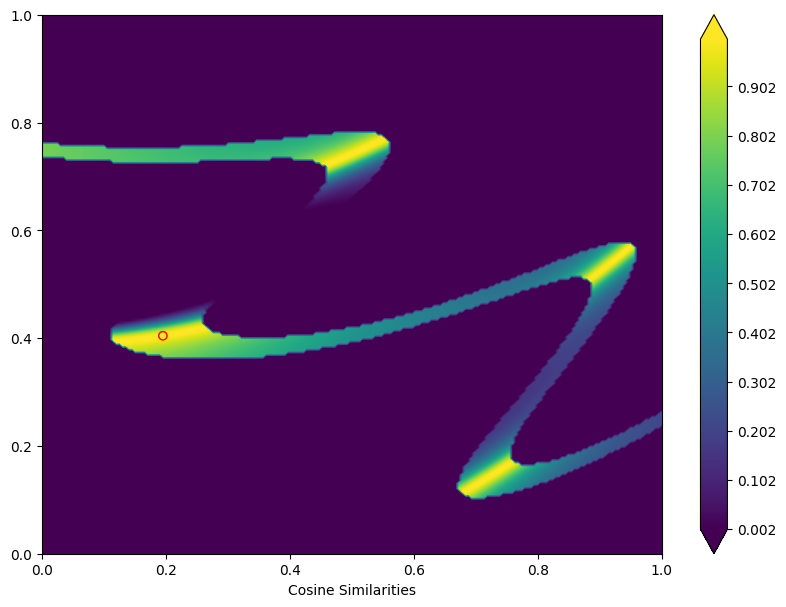

In [153]:
fig, ax = plt.subplots(1,1, figsize=(10, 7))
cosine_plot = ax.contourf(xs, ys, tf.reshape(cosine_sims, [y_list.shape[0], x_list.shape[0]]), levels=500,
                           extend="both")
ax.scatter(0.1954, 0.4044, facecolors='none', edgecolors='r')
fig.colorbar(cosine_plot)
ax.set_xlabel("Cosine Similarities")

Text(0.5, 0, 'Cosine Similarities')

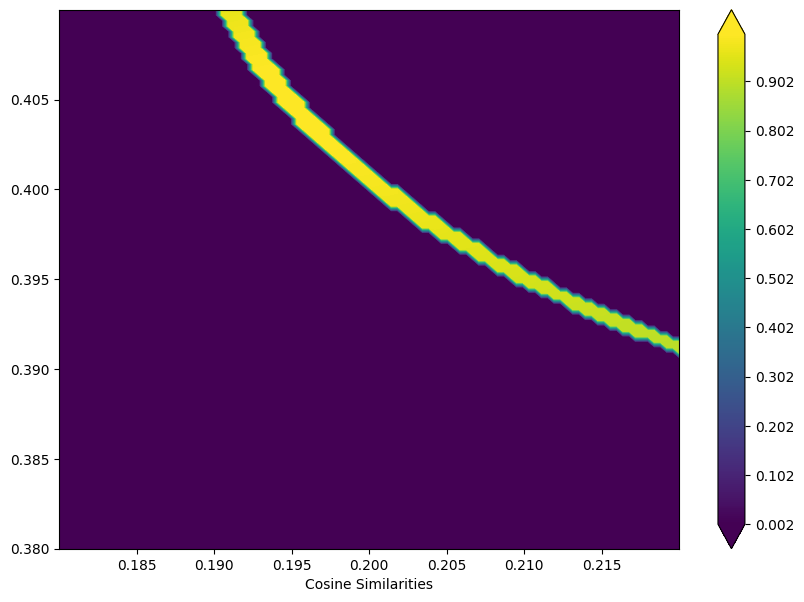

In [147]:
x_list = tf.linspace(0.18, 0.22, 100)
y_list = tf.linspace(0.38, 0.41, 100)
xs, ys = tf.meshgrid(x_list, y_list)
coordinates = tf.expand_dims(tf.stack((tf.reshape(xs, [-1]), tf.reshape(ys, [-1])), axis=1), -2)
cosine_sims = cosine_similarities(coordinates)
fig, ax = plt.subplots(1,1, figsize=(10,7))
cosine_plot = ax.contourf(xs, ys, tf.reshape(cosine_sims, [y_list.shape[0], x_list.shape[0]]), levels=500,
                           extend="both")
fig.colorbar(cosine_plot)
ax.set_xlabel("Cosine Similarities")

Text(0.5, 0, 'Cosine Similarities')

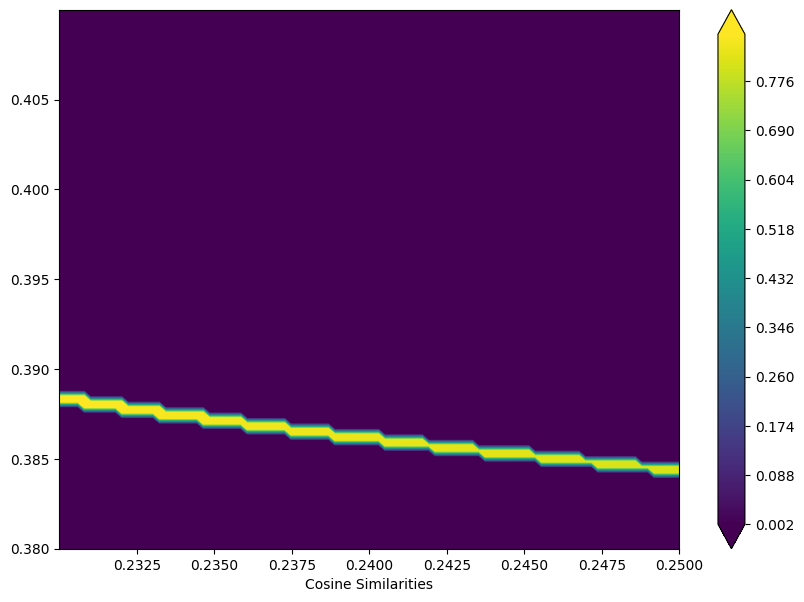

In [148]:
x_list = tf.linspace(0.23, 0.25, 100)
y_list = tf.linspace(0.38, 0.41, 100)
xs, ys = tf.meshgrid(x_list, y_list)
coordinates = tf.expand_dims(tf.stack((tf.reshape(xs, [-1]), tf.reshape(ys, [-1])), axis=1), -2)
cosine_sims = cosine_similarities(coordinates)
fig, ax = plt.subplots(1,1, figsize=(10,7))
cosine_plot = ax.contourf(xs, ys, tf.reshape(cosine_sims, [y_list.shape[0], x_list.shape[0]]), levels=500,
                           extend="both")
fig.colorbar(cosine_plot)
ax.set_xlabel("Cosine Similarities")

In [135]:
x = tf.Variable([[0.24, 0.386]])
with tf.GradientTape(persistent=True) as tape:
    y = constraints.toy_constraint_one(x)
print(tape.gradient(y, x))
print(f"Cosine Similarities: {cosine_similarities(tf.expand_dims(x, 0))}")

tf.Tensor([[-0.6655021 -3.3937416]], shape=(1, 2), dtype=float32)
Lagrange Mult: [[0.339391]]
Cosine Similarities: [[0.82996112]]


In [136]:
x = tf.Variable([[0.24, 0.386]])
with tf.GradientTape(persistent=True) as tape:
    y = objectives.linear_objective(x)
print(tape.gradient(y, x))
print(f"Cosine Similarities: {cosine_similarities(tf.expand_dims(x, 0))}")

tf.Tensor([[1. 1.]], shape=(1, 2), dtype=float32)
Lagrange Mult: [[0.339391]]
Cosine Similarities: [[0.82996112]]


In [140]:
est_grad = 0.339391 * tf.Variable([[-0.6655021, -3.3937416]])
true_grad = tf.Variable([[-1.0, -1.0]])
normalized_est_objective_grad = tf.math.l2_normalize(est_grad, axis=1)
normalized_true_objective_grad = tf.math.l2_normalize(true_grad, axis=1)
cosine_similarity = tf.reduce_sum(tf.multiply(normalized_est_objective_grad, normalized_true_objective_grad))

In [141]:
cosine_similarity

<tf.Tensor: shape=(), dtype=float32, numpy=0.8299611>

### Gradient Field of Toy Constraint One

In [43]:
x_list = tf.linspace(0, 1, 20)
y_list = tf.linspace(0, 1, 20)
xs, ys = tf.meshgrid(x_list, y_list)
coordinates = tf.expand_dims(tf.stack((tf.reshape(xs, [-1]), tf.reshape(ys, [-1])), axis=1), -2)
squeezed_coordinates = tf.squeeze(coordinates, -2)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(squeezed_coordinates)
    y = constraints.toy_constraint_one(squeezed_coordinates)

constraint_grad = tape.gradient(y, squeezed_coordinates)

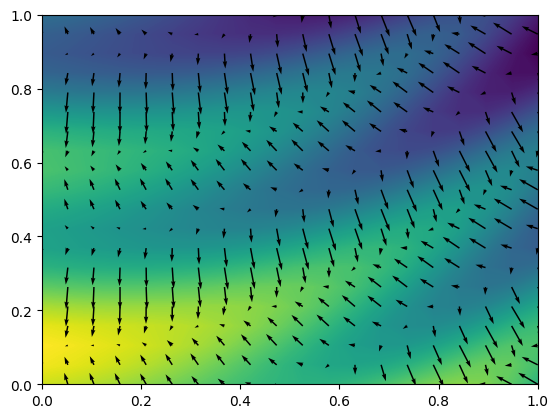

In [46]:
plt.quiver(xs, ys, tf.reshape(constraint_grad[:,0], xs.shape), tf.reshape(constraint_grad[:,1], ys.shape), zorder=1)
plt.contourf(xs, ys, tf.reshape(y, [y_list.shape[0], x_list.shape[0]]), levels=500, zorder=0)

In [50]:
x_list = tf.linspace(0, 1, 100)
y_list = tf.linspace(0, 1, 100)
xs, ys = tf.meshgrid(x_list, y_list)
coordinates = tf.expand_dims(tf.stack((tf.reshape(xs, [-1]), tf.reshape(ys, [-1])), axis=1), -2)
squeezed_coordinates = tf.squeeze(coordinates, -2)

with tf.GradientTape(persistent=True) as tape:
    tape.watch(squeezed_coordinates)
    y = constraints.toy_constraint_one(squeezed_coordinates)

constraint_grad = tape.gradient(y, squeezed_coordinates)

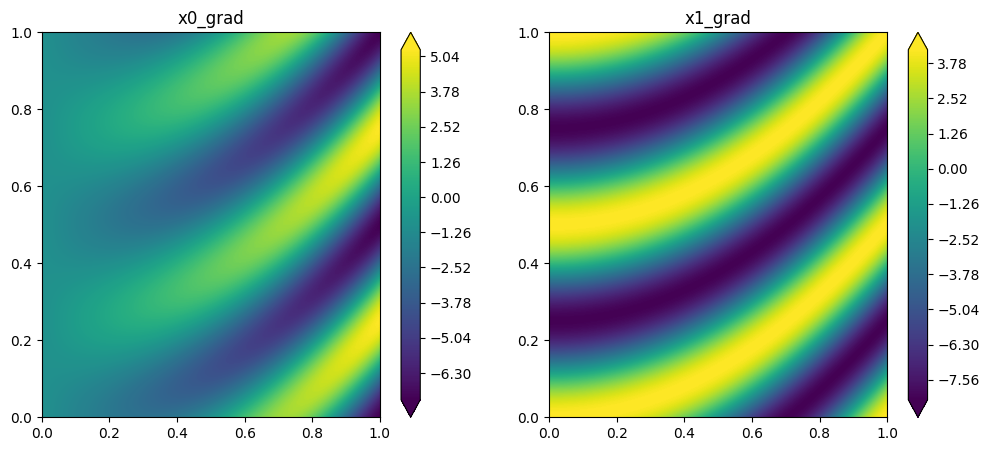

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
x0_grad_plot = ax[0].contourf(xs, ys, tf.reshape(constraint_grad[:,0], [y_list.shape[0], x_list.shape[0]]), levels=500,
                           extend="both")
ax[0].set_title("x0_grad")
fig.colorbar(x0_grad_plot)
x1_grad_plot = ax[1].contourf(xs, ys, tf.reshape(constraint_grad[:,1], [y_list.shape[0], x_list.shape[0]]), levels=500,
                           extend="both")
ax[1].set_title("x1_grad")
fig.colorbar(x1_grad_plot)

In [78]:
from scipy.stats import norm
norm.ppf(0.90)

1.2815515655446004